In [1]:

from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import LocalOutlierFactor

from category_encoders import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

###
### Data

In [2]:
d_tr = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/train.csv', index_col='Id')
d_te = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/test.csv', index_col='Id')

> **Training** and **test** sets  
> Deliting a **zero varianza** columns

In [3]:
# Utilities has just 2 categories, and one of them
# just appears once so we delete the whole column.
d_tr = d_tr.drop(columns='Utilities')
d_te = d_te.drop(columns='Utilities')

> A set of the **raw columns**

In [ ]:
raw_columns = set( all_d.columns )

## Analyzing 'y' or 'SalePrice'

> **outliners**, **RobustScaler()**, and **PowerTranformer()**

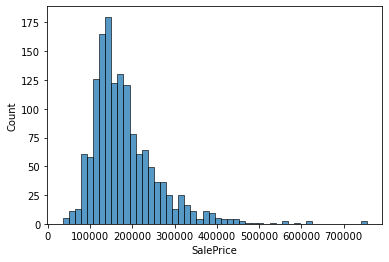

In [4]:
# chequing the distribution of 'y' = 'SalePrice'
sns.histplot( d_tr['SalePrice'], bins=50);

> **outliners** from **documentation**

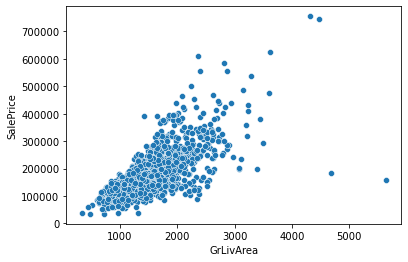

In [5]:
sns.scatterplot(x=d_tr['GrLivArea'], y=d_tr['SalePrice']);

In [4]:
outliers = d_tr[d_tr['GrLivArea'] >= 4500].index

In [5]:
# deleting the outliers in 'GrLivArea'
d_tr.drop(outliers, inplace=True)

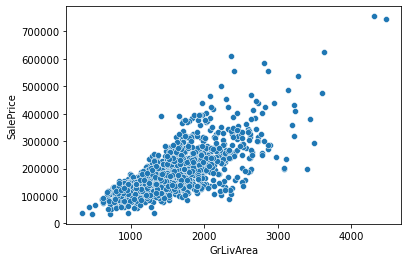

In [8]:
# cheking again
sns.scatterplot(x=d_tr['GrLivArea'], y=d_tr['SalePrice']);

In [6]:
# pipeline to scale and do a powerTransforme on y('SalePrice')
fix_y = Pipeline([('scaler', RobustScaler()), ('power', PowerTransformer(method='yeo-johnson'))])

In [7]:
y = fix_y.fit_transform(d_tr['SalePrice'].values.reshape(-1, 1))

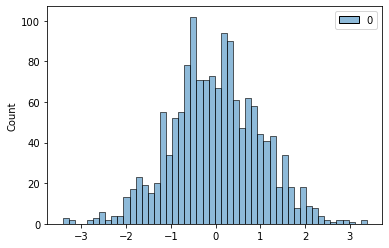

In [11]:
# checking the distribution of 'y' again
sns.histplot(y, bins=50);

> putting back **y** into **d_tr** 

In [8]:
d_tr['SalePrice'] = y

> combining **d_tr** and **d_te**

In [9]:
all_d = pd.concat([d_tr.copy(), d_te.copy()])

In [ ]:
all_d.head(7)

## Imputing **nan**

> columns with **nan**

In [ ]:
nan_columns = all_d.columns[all_d.isna().any()].to_list()

print('number of columns that has nan: ', len(nan_columns)) #This inclued 'SalesPrice' columns

> **coustum** Functions and Transformers

In [10]:
# 34 columns with nan

def fillWithNone(df):
    ''' nan in 'PoolQC' means 'no pool' 
        nan in 'MiscFeature' means 'no misc feature'
        nan in 'Alley' means 'no alley acces'
        nan in 'Fence' means 'no fence'
        nan in 'FireplaceQu' means 'no Fireplace'
        nan in 'GarageType', 'GarageFinish', 'GarageQual',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'
            'BsmtFinType1', 'MasVnrType', 'MSSubClass'
            'GarageCond' replaced with 'None' too
    
        recive a df
    '''
    
    df = df.copy()
    
    columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 
               'FireplaceQu', 'GarageType', 'GarageFinish', 
               'GarageQual', 'GarageCond', 'BsmtQual',
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
               'BsmtFinType2', 'MasVnrType'
              ]
    
    for col in columns:
        df[col] = df[col].fillna('None')
    
    return df

def fillWithZero(df):
    ''' nan 
    
    '''
    
    df = df.copy()
    
    columns = ['GarageYrBlt', 'GarageArea', 'GarageCars',
               'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
               'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
               'MasVnrArea'
              ]
    
    for col in columns:
        df[col] = df[col].fillna(0)
    
    return df

def fillWithMode(df):
    ''' fill missing values with mode, median
    '''
    df = df.copy()
    
    columns = ['Electrical', 'KitchenQual', 'Exterior1st',
               'Exterior2nd', 'SaleType'
              ]
    
    for col in columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # filling with median of each 'Neighborhood'
    df['LotFrontage'] = (
                     df.groupby('Neighborhood')['LotFrontage']
                     .transform(lambda x: x.fillna(x.median()))
                    )  
    
    # nan means Typical
    df['Functional'] = df['Functional'].fillna('Typ')
    
    return df


def mszoning(df):
    ''' recives a DF this imputation takes place on test data only'''
    
    df = df.copy()
    
    idotrr = ( (df['Neighborhood'] == 'IDOTRR') & (df['MSZoning'].isna()) )
    mitchel = ( (df['Neighborhood'] == 'Mitchel') & (df['MSZoning'].isna()) )
    
    df.loc[ idotrr , 'MSZoning'] = 'RM'
    df.loc[ mitchel, 'MSZoning'] = 'RL'
    
#     # to test this function out of here
#     temp = mszoning(d_te)
#     # lable index acces at [1916, 2217, 2251, 2905
#     temp.loc[[1916, 2217, 2251, 2905], 'MSZoning']
    
    return df
    
none_func = FunctionTransformer(fillWithNone, validate=False) 
zero_func = FunctionTransformer(fillWithZero, validate=False) 
mode_func = FunctionTransformer(fillWithMode, validate=False)
mszo_func = FunctionTransformer(mszoning, validate=False)

> getting the **imputer**

In [11]:
imputer = Pipeline([
                    ('withNone', none_func), 
                    ('withZero', zero_func), 
                    ('withMode', mode_func), 
                    ('mszoni', mszo_func)
                   ])

> Imputing

In [12]:
new_d = imputer.fit_transform(all_d)

> checking if there is any columns with **nan**

In [ ]:
new_d.columns[new_d.isna().any()].to_list()

In [ ]:
new_d.SalePrice.tail(7)

## Categorical

> Reducing **low frequency** categories

In [13]:
# Low frequency categories to 'Other'

def lower_than(df, col, percentage):
    ''' function that will merge low frequency classes into 
        a single class 'Others'
        
        parameters:
            df: a DataFrame
            col: column's name to work on
            percentage(%): the threshold like 0.1, 0.2
            
        returns:
            df: the data frame with col's classes that are lowers
                than 'threshold' been repleced with 'Other' category
    '''
    
    # calculating the column frequency
    col_freq = df[col].value_counts(normalize=True)
    
    # the getting the column threshold 
    threshold = col_freq.quantile(q= percentage)
    
    # knowing the classes that are below the threshold
    less_freq_classes = col_freq[ col_freq <= threshold ]
    
    others = less_freq_classes.index.to_list()
    
    print(others)
    
    df[col] = df[col].replace(others, 'Others')
    
    return df



con1_others = ['RRAn', 'PosN', 'RRAe', 'PosA', 'RRNn', 'RRNe']
roofS_others = ['Gambrel', 'Flat', 'Mansard', 'Shed']
foun_others = ['Slab', 'Stone', 'Wood']
gara_others = ['None', 'Basment', '2Types', 'CarPort']
saleT_others = ['ConLD', 'CWD', 'ConLI', 'ConLw', 'Oth', 'Con']
saleC_others = ['Family', 'Alloca', 'AdjLand']
exte1_others = ['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc']
exte2_others = ['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc', 'Other']
lotC_others = ['FR2', 'FR3']

new_d['Condition1'] = new_d['Condition1'].map(lambda x: 'Others' if x in con1_others else x)
new_d['RoofStyle'] = new_d['RoofStyle'].map(lambda x: 'Others' if x in roofS_others else x)
new_d['Foundation'] = new_d['Foundation'].map(lambda x: 'Others' if x in foun_others else x)
new_d['GarageType'] = new_d['GarageType'].map(lambda x: 'Others' if x in gara_others else x)
new_d['SaleType'] = new_d['SaleType'].map(lambda x: 'Others' if x in saleT_others else x)
new_d['SaleCondition'] = new_d['SaleCondition'].map(lambda x: 'Others' if x in saleC_others else x)
new_d['Exterior1st'] = new_d['Exterior1st'].map(lambda x: 'Others' if x in exte1_others else x)
new_d['Exterior2nd'] = new_d['Exterior2nd'].map(lambda x: 'Others' if x in exte2_others else x)
new_d['LotConfig'] = new_d['LotConfig'].map(lambda x: 'Others' if x in lotC_others else x)


# Reducing to a BINARY CLASSES(just 2 clases)

landC_others = ['HLS', 'Bnk', 'Low']
cond2_others = ['Feedr', 'Artery', 'PosN', 'PosA', 'RRNn', 'RRAn', 'RRAe']
roofM_others = ['Tar&Grv', 'WdShake', 'WdShngl', 'Metal', 'Membran', 'Roll', 'ClyTile']
heati_others = ['GasW', 'Grav', 'Wall', 'OthW', 'Floor']
elect_others = ['FuseA', 'FuseF', 'FuseP', 'Mix']
miscF_others = ['Shed', 'Gar2', 'Othr', 'TenC']

new_d['LandContour'] = new_d['LandContour'].map(lambda x: 'Others' if x in landC_others else x)
new_d['Condition2'] = new_d['Condition2'].map(lambda x: 'Others' if x in cond2_others else x)
new_d['RoofMatl'] = new_d['RoofMatl'].map(lambda x: 'Others' if x in roofM_others else x)
new_d['Heating'] = new_d['Heating'].map(lambda x: 'Others' if x in heati_others else x)
new_d['Electrical'] = new_d['Electrical'].map(lambda x: 'Others' if x in elect_others else x)

new_d['MiscFeature'] = new_d['MiscFeature'].map(lambda x: 'Others' if x in miscF_others else x)

# # to encode using OneHot (14 so far)
# cat_to_1Hot = {'Condition1': str, 'RoofStyle': str, 'Foundation': str, 'GarageType': str, 'SaleType': str, 
#                'SaleCondition': str, 'Exterior1st': str, 'Exterior2nd': str, 'LotConfig': str, 'LandContour': str, 
#                'Condition2': str, 'RoofMatl': str, 'Heating': str, 'Electrical': str }

# # updating data types
# new_d = new_d.astype(cat_to_1Hot)

> Getting the **column names** for  
> - OneHot() encoder  
> - and **updating data type**

In [14]:
# to encode using OneHot (15 so far)
cat_to_1Hot = {'Condition1': str, 'RoofStyle': str, 'Foundation': str, 'GarageType': str, 'SaleType': str, 
               'SaleCondition': str, 'Exterior1st': str, 'Exterior2nd': str, 'LotConfig': str, 'LandContour': str, 
               'Condition2': str, 'RoofMatl': str, 'Heating': str, 'Electrical': str, 'MiscFeature': str }

# updating data types of the columns 
# that  we just reduced 
new_d = new_d.astype(cat_to_1Hot)

###
> Reducing number of classes in **'Neighborhood'** and **'MSSubClass'**   Using **Clusters**

In [15]:
def make_clusters(df, col, y, n_cluster, merge=False):
    '''
        function to boil down a colum to n_cluster
        
        recive:
        
            df: a data frame 
            col: col to make cluster
            y: the response variable
            n_cluster: stamitation of number of cluster
            
        return:  
            a data frame with 'col' droped, and 'col' + '_cluster' column
            is added to the data frame

        
    '''
    col_clusters = KMeans(n_clusters=n_cluster, random_state=777)

    # 'Neighborhood' and 'MSSubClass' stats
    col_stats = df.groupby(col)[y].describe()

    # Getting clusters
    col_clusters.fit(col_stats)

    # preparing DF with cluster lables to merge
    new_name = col + '_Cluster'
    col_cluster_df = pd.DataFrame( { col: col_stats.index.to_list(),
                                     new_name: col_clusters.labels_.tolist()} )
    
    if merge:
        # merging the clusters with the data frame
        df = df.merge(col_cluster_df, how='left', on=col)

        df[new_name] = df[new_name].astype(str)
        
        result = df.drop(columns=col)
        
    else:
        result = col_cluster_df
    
    return result

## Features ingenering

In [16]:
# Creating a new feature 'PeakMonths', 'Unfinished',
# 'Splited', and TotalSF
peak_moS = [5, 6, 7]
unfi_hou = ['1.5Unf', '2.5Unf']
spli_hou = ['SFoyer', 'SLvl']

new_d['PeakMonths'] = new_d['MoSold'].map(lambda x: 'Peak' if x in peak_moS else 'Normal' )
new_d['Finished'] = new_d['HouseStyle'].map(lambda x: 'no' if x in unfi_hou else 'yes') 
new_d['Splited'] = new_d['HouseStyle'].map(lambda x: 'yes' if x in spli_hou else 'no')

new_d['TotalSF'] = new_d['TotalBsmtSF'] + new_d['1stFlrSF'] + new_d['2ndFlrSF']


# we will use the training data because if we uses new_d
# it has 'nan' in 'SalePrice'. test data does not have 'SalePrice'
# 'Neighborhood', 5, 'MSSubClass', 4
nei_cluster = make_clusters(d_tr.copy(), 'Neighborhood', 'SalePrice', 5)
mss_cluster = make_clusters(d_tr.copy(), 'MSSubClass', 'SalePrice', 4)

# merging the clusters with the data frame
# we got a 'nan' cluster becouse 'MSSubClass' in test
# has a '150' class that is just in test
new_d = new_d.merge(nei_cluster, how='left', on='Neighborhood')
new_d.drop(columns='Neighborhood', inplace=True)

new_d = new_d.merge(mss_cluster, how='left', on='MSSubClass')
new_d.drop(columns='MSSubClass', inplace=True)


# updating types
new_d = new_d.astype( {'PeakMonths':str, 'Finished':str, 'Splited':str,
                       'Neighborhood_Cluster': str, 'MSSubClass_Cluster': str} )

# updating cat_to_1Hot
cat_to_1Hot.update( {'PeakMonths':str, 'Finished':str, 'Splited':str,
                       'Neighborhood_Cluster': str, 'MSSubClass_Cluster': str} )

In [ ]:
new_d[cat_to_1Hot.keys()].info()

## Maping for Ordinal Categorical

In [17]:
##### ****** All writed by me ****** #####
##########################################

ord_cat_mapping = [
    {
        'col': 'FireplaceQu',
        'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    },
    {
        'col': 'GarageQual',
        'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    },
    {
        'col': 'GarageCond',
        'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    },
    {
        'col': 'BsmtFinType1',
        'mapping': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
    },
    {
        'col': 'BsmtFinType2',
        'mapping': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
    },
    {
        'col': 'ExterQual',
        'mapping': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
    },
    {
        'col': 'ExterCond',
        'mapping': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    },
    {
        'col': 'BsmtQual',
        'mapping': {'None': 0 , 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    },
    {
        'col': 'BsmtCond',
        'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4}
    },
    {
        'col': 'PoolQC',
        'mapping': {'None': 0, 'Fa': 1, 'Gd': 2, 'Ex': 3}
    },
    {
        'col': 'HeatingQC',
        'mapping': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    },
    {
        'col': 'KitchenQual',
        'mapping': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
    },
    {
        'col': 'BsmtExposure',
        'mapping': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
    },
    {
        'col': 'Functional',
        'mapping': {'Sev': 0, 'Maj2': 1, 'Maj1': 2, 'Mod': 3, 'Min2': 4, 'Min1': 5, 'Typ': 6}
    },
    {
        'col': 'GarageFinish',
        'mapping': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
    },
    {
        'col': 'Fence',
        'mapping': {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
    },
    {
        'col': 'CentralAir',
        'mapping': {'N': 0, 'Y': 1}
    },
    {
        'col': 'PavedDrive',
        'mapping': {'N': 0, 'P': 1, 'Y': 2}
    },
    {
        'col': 'Street',
        'mapping': {'Grvl': 0, 'Pave': 1}
    },
    {
        'col': 'Alley',
        'mapping': {'None': 0, 'Grvl': 1, 'Pave': 2}
    },
    {
        'col': 'LandSlope',
        'mapping': {'Gtl': 0, 'Mod': 1, 'Sev': 2}
    },
    {
        'col': 'LotShape',
        'mapping': {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}
    },
    {
        'col': 'HouseStyle', 
        'mapping': {'SLvl': 0, 'SFoyer': 0, '1Story': 1, '1.5Fin': 2, 
                    '1.5Unf': 2, '2Story': 3, '2.5Unf': 4, '2.5Fin': 4}
    }
]

# list of categorical columns(23)  
# that we just encoded
ord_cat_DONE = {'FireplaceQu': str, 'GarageQual': str,'GarageCond': str,'BsmtFinType1': str,
                 'BsmtFinType2': str,'ExterQual': str,'ExterCond': str,'BsmtQual': str,
                 'BsmtCond': str,'PoolQC': str,'HeatingQC': str,'KitchenQual': str,
                 'BsmtExposure': str,'Functional': str,'GarageFinish': str,'Fence': str, 
                 'CentralAir': str, 'PavedDrive': str,'Street': str,'Alley': str,
                 'LandSlope': str,'LotShape': str, 'HouseStyle': str}

# object columns (need to be analyzed)
# cat_NoDone = ['MSZoning', 'BldgType', 'MasVnrType', 'MiscFeature']
# {'BldgType', 'MSZoning', 'MasVnrType', 'MiscFeature'}

###
> **Updating columns types**

In [21]:
# updating the types
# update the list of ordinal with 2 columns name
# that allredy are ordinal and encoded ('OverallQual', 'OverallCond')
 
ord_cat_DONE.update({'OverallQual': str, 'OverallCond': str})
new_d = new_d.astype(ord_cat_DONE)

# 5 more columns will concidere as categorical
cat_to_1Hot.update({'MoSold': str, 'YrSold': str, 'BldgType':str, 
                    'MSZoning': str, 'MasVnrType': str})

new_d = new_d.astype(cat_to_1Hot)

##
> **BEFORE** Ordinal and OneHot encoder  
> - safe **the number columns names**
> - check if we've **analyzed** all columns

In [19]:
numbers_col = new_d.select_dtypes('number')
numbers_col = numbers_col.columns.to_list()

In [20]:
# the first time I checked I got
# {'BldgType', 'MSZoning', 'MasVnrType', 'MiscFeature'}
# I went back and analyze them!

analyzed_col = numbers_col + list(cat_to_1Hot.keys()) + list(ord_cat_DONE.keys())
set( new_d.columns.to_list() ) - set( analyzed_col )

{'BldgType', 'MSZoning', 'MasVnrType'}

###
> doing the **Ordinal Encode**

In [ ]:
## OrdinalEncoder
oe = OrdinalEncoder(mapping=ord_cat_mapping)

In [ ]:
# encoding Ordinal categories columns
new_d = oe.fit_transform(new_d)

###
> doing **OneHot Encoding**  

In [ ]:
# OneHot encoding
oh = OneHotEncoder(cols=cat_to_1Hot).fit(new_d.copy())

In [ ]:
new_d = oh.transform(new_d.copy())

## Numerical

In [23]:
print('numbers  : ', len(numbers_col))
print('to OneHot: ', len(list(cat_to_1Hot.keys())))
print('Ordinal. : ', len(list(ord_cat_DONE.keys())))

numbers  :  33
to OneHot:  25
Ordinal. :  25


In [24]:
new_d.shape
# {'BldgType', 'MSZoning', 'MasVnrType'}

(2917, 83)

In [42]:
skewed_col = new_d.skew(numeric_only=True)

In [47]:
skewed_col = skewed_col[ skewed_col > 0.7 ]
skewed_col = skewed_col.index
len(skewed_col)

22

In [44]:
fix_skew = Pipeline([('scaler', RobustScaler()), ('transform', PowerTransformer(method='yeo-johnson'))])

In [55]:
new_d[skewed_col].skew(numeric_only=True)

LotFrontage       1.103606
LotArea          13.116240
MasVnrArea        2.623068
BsmtFinSF1        0.981149
BsmtFinSF2        4.146636
BsmtUnfSF         0.920161
1stFlrSF          1.257933
2ndFlrSF          0.861999
LowQualFinSF     12.090757
GrLivArea         1.069300
BsmtHalfBath      3.932018
KitchenAbvGr      4.302763
TotRmsAbvGrd      0.749618
Fireplaces        0.725651
WoodDeckSF        1.845741
OpenPorchSF       2.530660
EnclosedPorch     4.004404
3SsnPorch        11.377932
ScreenPorch       3.947131
PoolArea         17.697766
MiscVal          21.950962
TotalSF           1.009676
dtype: float64

In [56]:
# temp01 = new_d.copy()
new_d[skewed_col] = fix_skew.fit_transform(new_d[skewed_col]) 

In [57]:
new_d[skewed_col].skew(numeric_only=True)

LotFrontage       0.057766
LotArea          -0.083557
MasVnrArea        0.634312
BsmtFinSF1        0.170616
BsmtFinSF2        2.355281
BsmtUnfSF         0.076525
1stFlrSF          0.013987
2ndFlrSF          0.382822
LowQualFinSF      8.367252
GrLivArea         0.032513
BsmtHalfBath      3.707631
KitchenAbvGr     -4.580326
TotRmsAbvGrd     -0.003151
Fireplaces        0.253315
WoodDeckSF        0.332826
OpenPorchSF       0.313835
EnclosedPorch     1.883004
3SsnPorch         8.713711
ScreenPorch       2.915386
PoolArea         15.502729
MiscVal           5.038164
TotalSF          -0.008523
dtype: float64

# Feature Selection

In [60]:
d_tr.tail(7)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1454,20,RL,90.0,17217,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,NaN,NaN,NaN,0,7,2006,WD,Abnorml,-1.798531
1455,20,FV,62.0,7500,Pave,Pave,Reg,Lvl,Inside,Gtl,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,0.321856
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,0.180704
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,0.630526
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,1.175759
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,-0.386845
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,-0.282014


In [61]:
new_d[1459:1461]

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,...,YrSold,SaleType,SaleCondition,SalePrice,PeakMonths,Finished,Splited,TotalSF,Neighborhood_Cluster,MSSubClass_Cluster
1459,RL,0.603501,0.965879,Pave,None,IR1,Lvl,Corner,Gtl,Norm,...,2010,WD,Normal,NaN,Peak,yes,no,0.278550,2,1.0
1460,RL,0.289528,0.905394,Pave,None,IR1,Lvl,Inside,Gtl,Norm,...,2010,WD,Normal,NaN,Normal,yes,no,0.149007,0,2.0
